###  MicroGrad demo

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

2024-05-25 15:38:37.027281: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
np.random.seed(1337)
random.seed(1337)

In [3]:
# Загрузка данных MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Преобразование данных в формат float32
x_train = x_train.astype('float64') / 255.0 * 2 - 1
x_test = x_test.astype('float64') / 255.0 * 2 - 1

# Изменение формы данных
x_train = x_train.reshape(x_train.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)

# One-hot кодирование меток
y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test_oh = tf.keras.utils.to_categorical(y_test, num_classes=10)

y_train_oh = y_train_oh * 2 - 1
y_test_oh = y_test_oh * 2 - 1

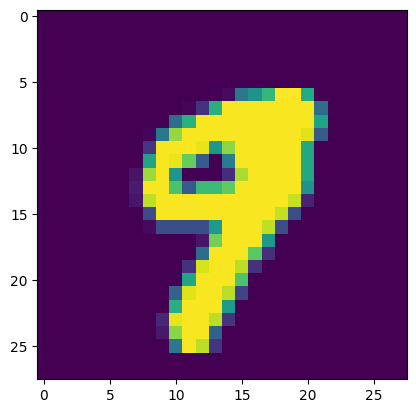

In [4]:
def draw_some(numbers):
    number = numbers[random.randint(0, numbers.shape[0] - 1)]
    plt.imshow(number.reshape([28, 28]))

draw_some(x_train)

In [5]:
from collections import defaultdict

POSITIVE_CLASSES = [0]

def balance(x, y, positive_classes):
    assert -1 not in positive_classes

    p_idx = np.where(np.isin(y, positive_classes))[0]
    n_idx = np.where(~np.isin(y, positive_classes))[0]
    len = min(p_idx.shape[0], n_idx.shape[0])
    p_idx = np.random.permutation(p_idx)[:len]
    n_idx = np.random.permutation(n_idx)[:len]
    idx = np.random.permutation(np.concatenate([p_idx, n_idx]))
    x, y = x[idx], y[idx]

    return x, y

X, Y = balance(x_train, y_train, POSITIVE_CLASSES)

def oh_encode(y, positive_classes):
    gray = np.array([-1] * len(positive_classes))
    oh_enc = defaultdict(lambda: gray)
    oh_dec = defaultdict(lambda: None)
    for i, cls in enumerate(positive_classes):
        cls_vec = np.array([-1.0] * len(positive_classes))
        cls_vec[i] = 1.0
        oh_enc[cls] = cls_vec
        oh_dec[tuple(cls_vec)] = cls

    return oh_dec, np.array([oh_enc[cls] for cls in y])

OH_DEC, Y_oh = oh_encode(Y, POSITIVE_CLASSES)
OH_DEC, Y_oh.shape

(defaultdict(<function __main__.oh_encode.<locals>.<lambda>()>, {(1.0,): 0}),
 (11846, 1))

In [6]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

# initialize a model
model = MLP(
    784,
    [
        (10, 'tanh'),
        (1, 'tanh')
    ]
)
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [tanh-Neuron(784), tanh-Neuron(784), tanh-Neuron(784), tanh-Neuron(784), tanh-Neuron(784), tanh-Neuron(784), tanh-Neuron(784), tanh-Neuron(784), tanh-Neuron(784), tanh-Neuron(784)], Layer of [tanh-Neuron(10)]]
number of parameters 7861


In [7]:
def batch(X, Y_oh, batch_size):
    ri = np.random.permutation(X.shape[0])[:batch_size]
    X, Y_oh = X[ri], Y_oh[ri]

    input = [list(map(Value, xi)) for xi in X]
    ground_truths = [list(map(Value, yi)) for yi in Y_oh]

    return input, ground_truths

In [8]:
# loss function
def one_loss(score, ground_truth):
    return sum((s - gt)**2 for s, gt in zip(score, ground_truth))


def decode(values):
    encoded = tuple(np.array([v.data for v in values]).round())
    return OH_DEC[encoded]


def accuracy(scores, ground_truths):
    matches = 0
    for score, ground_truths in zip(scores, ground_truths):
        matches += decode(score) == decode(ground_truths)

    return matches / len(scores)

def loss(input, ground_truths):
    scores = list(map(model, input))
    total_loss = sum(one_loss(s, gt) for s, gt in zip(scores, ground_truths))

    return total_loss, accuracy(scores, ground_truths)

total_loss, acc = loss(*batch(X, Y_oh, 1))
total_loss.data, acc

(1.014128100308858, 1.0)

In [9]:
BATCH_SIZE = 8
BATCH = batch(X, Y_oh, BATCH_SIZE)

# optimization
for k in range(15):

    # forward
    total_loss, acc = loss(*BATCH)
    print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

    # backward
    model.zero_grad()
    total_loss.backward()

    # update (sgd)
    # learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        #p.data += -learning_rate * p.grad
        p.learn(0.5)

total_loss, acc = loss(*BATCH)
print(f"final loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 12.483471402540358, accuracy 50.0%
step 1 loss 7.675580558358616, accuracy 62.5%
step 2 loss 16.01286805923587, accuracy 50.0%
step 3 loss 11.999999999999998, accuracy 62.5%
step 4 loss 11.619632744772225, accuracy 62.5%
step 5 loss 7.9999998783184125, accuracy 75.0%
step 6 loss 7.973323124671092, accuracy 75.0%
step 7 loss 7.999989832774599, accuracy 75.0%
step 8 loss 3.9189653940928295, accuracy 87.5%
step 9 loss 3.9996179373465255, accuracy 87.5%
step 10 loss 3.5088679700733936, accuracy 87.5%
step 11 loss 0.0002052714426612065, accuracy 100.0%
step 12 loss 0.0001846889555431578, accuracy 100.0%
step 13 loss 1.052118674274624e-08, accuracy 100.0%
step 14 loss 1.2673655137361726e-15, accuracy 100.0%
step 15 loss 1.2773293367266192e-21, accuracy 100.0%
step 16 loss 3.5622000251386314e-30, accuracy 100.0%
step 17 loss 0.0, accuracy 100.0%
step 18 loss 0.0, accuracy 100.0%
step 19 loss 0.0, accuracy 100.0%
step 20 loss 0.0, accuracy 100.0%
step 21 loss 0.0, accuracy 100.0%
s

KeyboardInterrupt: 

In [10]:
parameters = model.parameters()
parameters.sort(key=lambda p: p.grad)
parameters

[Value(data=-0.7007105820577706, pgrad=8.815793722646183e-05, grad=-0.000299486971222083, lr=0.00044118487682861656),
 Value(data=0.7502040608552493, pgrad=8.815798384974388e-05, grad=-0.000299486924581424, lr=0.0004411849455347205),
 Value(data=0.16565900258690278, pgrad=8.815821968201248e-05, grad=-0.0002994866886755202, lr=0.0004411852932861003),
 Value(data=0.9890606181368489, pgrad=8.815928484103683e-05, grad=-0.0002994856231840071, lr=0.00044118686394579266),
 Value(data=-0.2709165717998422, pgrad=8.816017953336705e-05, grad=-0.00029948472826731606, lr=0.00044118818273071057),
 Value(data=-0.13240287567063388, pgrad=8.816021015249565e-05, grad=-0.0002994846975730336, lr=0.0004411882282423686),
 Value(data=0.7095504190356221, pgrad=8.816028062281486e-05, grad=-0.0002994846271442812, lr=0.00044118833176418233),
 Value(data=-0.39067114069162745, pgrad=8.816087718075321e-05, grad=-0.0002994840304086723, lr=0.0004411892139806662),
 Value(data=-0.15437799711234287, pgrad=8.816102801176